In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ML

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
## PCA 주성분 개수
n = 2

In [5]:
df = pd.read_csv("thyroid_cancer_risk_data.csv")

# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "Diagnosis"
y = df[y_col]

# 독립 변수 설정
X = df.drop(columns=[y_col])

# 연속형 변수와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns

## PCA 적용 전 정규화 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[continuous_vars])

# PCA 적용
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(principal_components, columns=['PCA_1', 'PCA_2'])
df = pd.concat([df, df_pca], axis=1)

In [6]:
# 타겟 변수 (Diagnosis)
y_col = "Diagnosis"
y = df[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df.drop(columns=[y_col, "Patient_ID", "Country"])

# 연속형 변수 (float, int)와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

In [7]:
df_encoded = pd.get_dummies(df, columns=categorical_vars)
X = df_encoded.drop(columns=[y_col, "Patient_ID", "Country"])

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 수행
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # 'Benign' -> 0, 'Malignant' -> 1
y_test = le.transform(y_test)  

## Model

### Logistic Regression

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8251


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8238


### Decision Tree

In [12]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 3}
Accuracy: 0.8250311478878206
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### XGBoost

In [13]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:23:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.8250546557276852
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### LightGBM

In [14]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39571, number of negative: 130581
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 170152, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232563 -> initscore=-1.193897
[LightGBM] [Info] Start training from score -1.193897
🔹 LightGBM Model Performance 🔹
Accuracy: 0.8250781635675498
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



### CatBoost

In [15]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8250546557276852
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



# DL

In [16]:
## PCA 주성분 개수
n = 2

In [17]:
df = pd.read_csv("thyroid_cancer_risk_data.csv")

# Alzheimer’s Diagnosis를 종속 변수(y)로 설정
y_col = "Diagnosis"
y = df[y_col]

# 독립 변수 설정
X = df.drop(columns=[y_col])

# 연속형 변수와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns

## PCA 적용 전 정규화 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[continuous_vars])

# PCA 적용
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(principal_components, columns=['PCA_1', 'PCA_2'])
df = pd.concat([df, df_pca], axis=1)

In [18]:
# 분류 task
is_classification = True

In [19]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={#"Patient_ID" : numerical,
              "Age" : numerical,
              "Gender" : categorical,
              "Country" : categorical,
              "Ethnicity" : categorical,
              "Family_History" : categorical,
              "Radiation_Exposure" : categorical,
              "Iodine_Deficiency" : categorical,
              "Smoking" : categorical,
              "Obesity" : categorical,
              "Diabetes" : categorical,
              "TSH_Level" : numerical,
              "T3_Level" : numerical,
              "T4_Level" : numerical,
              "Nodule_Size" : categorical,
              "Thyroid_Cancer_Risk" : categorical,
              "Diagnosis" : categorical}

dataset = Dataset(df = df, 
                  col_to_stype = col_to_stype, 
                  target_col = "Diagnosis")

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [20]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [21]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [22]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [23]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [24]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [25]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 499/499 [00:09<00:00, 54.80it/s] 


Train Loss: 0.4585, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 2: 100%|██████████| 499/499 [00:04<00:00, 106.64it/s]


Train Loss: 0.4533, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:05<00:00, 85.81it/s]


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:05<00:00, 87.11it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:05<00:00, 86.37it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:05<00:00, 88.09it/s]


Train Loss: 0.4515, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:05<00:00, 97.30it/s] 


Train Loss: 0.4514, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:05<00:00, 94.68it/s] 


Train Loss: 0.4509, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:05<00:00, 96.94it/s] 


Train Loss: 0.4506, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:05<00:00, 88.98it/s] 


Train Loss: 0.4503, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:05<00:00, 96.58it/s] 


Train Loss: 0.4499, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:05<00:00, 87.64it/s] 


Train Loss: 0.4492, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:05<00:00, 86.05it/s]


Train Loss: 0.4489, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:05<00:00, 87.58it/s]


Train Loss: 0.4482, Train Acc: 0.8271, Val Acc: 0.8308, Test Acc: 0.8267


Epoch: 15: 100%|██████████| 499/499 [00:05<00:00, 85.50it/s]


Train Loss: 0.4475, Train Acc: 0.8272, Val Acc: 0.8308, Test Acc: 0.8266
Best Val Acc: 0.8309, Best Test Acc: 0.8268


In [26]:
resnet_score = best_test_metric
resnet_score

0.8267744918269155

### FT-T

In [27]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [28]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [29]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [30]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [31]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [32]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 499/499 [00:12<00:00, 39.90it/s]


Train Loss: 0.4600, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 2: 100%|██████████| 499/499 [00:11<00:00, 43.51it/s]


Train Loss: 0.4535, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:11<00:00, 44.27it/s]


Train Loss: 0.4530, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:10<00:00, 48.78it/s]


Train Loss: 0.4527, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:11<00:00, 43.17it/s]


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:09<00:00, 53.45it/s]


Train Loss: 0.4524, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:10<00:00, 45.68it/s]


Train Loss: 0.4524, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:10<00:00, 45.57it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:11<00:00, 41.95it/s]


Train Loss: 0.4523, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:11<00:00, 42.07it/s]


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:07<00:00, 67.71it/s]


Train Loss: 0.4520, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:11<00:00, 44.22it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:11<00:00, 42.30it/s]


Train Loss: 0.4520, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:10<00:00, 49.55it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:11<00:00, 41.99it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268
Best Val Acc: 0.8309, Best Test Acc: 0.8268


In [33]:
ftt_score = best_test_metric
ftt_score

0.8267744918269155

### TabNet

In [34]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [35]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [36]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [37]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [38]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1: 100%|██████████| 499/499 [00:09<00:00, 50.03it/s]


Train Loss: 0.4872, Train Acc: 0.8269, Val Acc: 0.8304, Test Acc: 0.8265


Epoch: 2: 100%|██████████| 499/499 [00:10<00:00, 48.44it/s]


Train Loss: 0.4570, Train Acc: 0.8271, Val Acc: 0.8310, Test Acc: 0.8266


Epoch: 3: 100%|██████████| 499/499 [00:10<00:00, 47.58it/s]


Train Loss: 0.4544, Train Acc: 0.8271, Val Acc: 0.8307, Test Acc: 0.8267


Epoch: 4: 100%|██████████| 499/499 [00:08<00:00, 56.17it/s] 


Train Loss: 0.4533, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8267


Epoch: 5: 100%|██████████| 499/499 [00:09<00:00, 50.21it/s]


Train Loss: 0.4527, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:10<00:00, 47.63it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8267


Epoch: 7: 100%|██████████| 499/499 [00:10<00:00, 48.47it/s]


Train Loss: 0.4513, Train Acc: 0.8271, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:09<00:00, 53.11it/s]


Train Loss: 0.4511, Train Acc: 0.8272, Val Acc: 0.8309, Test Acc: 0.8266


Epoch: 9: 100%|██████████| 499/499 [00:10<00:00, 48.42it/s]


Train Loss: 0.4506, Train Acc: 0.8272, Val Acc: 0.8309, Test Acc: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:10<00:00, 48.27it/s]


Train Loss: 0.4499, Train Acc: 0.8270, Val Acc: 0.8305, Test Acc: 0.8266


Epoch: 11: 100%|██████████| 499/499 [00:10<00:00, 47.57it/s]


Train Loss: 0.4495, Train Acc: 0.8272, Val Acc: 0.8308, Test Acc: 0.8267


Epoch: 12: 100%|██████████| 499/499 [00:10<00:00, 48.37it/s]


Train Loss: 0.4489, Train Acc: 0.8273, Val Acc: 0.8307, Test Acc: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:09<00:00, 52.48it/s] 


Train Loss: 0.4483, Train Acc: 0.8272, Val Acc: 0.8309, Test Acc: 0.8267


Epoch: 14: 100%|██████████| 499/499 [00:09<00:00, 49.93it/s]


Train Loss: 0.4479, Train Acc: 0.8274, Val Acc: 0.8307, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:10<00:00, 48.75it/s]


Train Loss: 0.4473, Train Acc: 0.8273, Val Acc: 0.8309, Test Acc: 0.8266
Best Val Acc: 0.8310, Best Test Acc: 0.8266


In [39]:
tabnet_score = best_test_acc
tabnet_score

0.8265707524252824

### Tab_Transformer

In [40]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [41]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [42]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [43]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [44]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 499/499 [00:15<00:00, 32.28it/s]


Train Loss: 0.5907, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 2: 100%|██████████| 499/499 [00:15<00:00, 32.50it/s]


Train Loss: 0.4691, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 3: 100%|██████████| 499/499 [00:14<00:00, 33.97it/s]


Train Loss: 0.4649, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 4: 100%|██████████| 499/499 [00:15<00:00, 32.37it/s]


Train Loss: 0.4605, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 5: 100%|██████████| 499/499 [00:15<00:00, 32.73it/s]


Train Loss: 0.4582, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 6: 100%|██████████| 499/499 [00:15<00:00, 33.11it/s]


Train Loss: 0.4585, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 7: 100%|██████████| 499/499 [00:15<00:00, 32.65it/s]


Train Loss: 0.4583, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 8: 100%|██████████| 499/499 [00:15<00:00, 32.49it/s]


Train Loss: 0.4567, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 9: 100%|██████████| 499/499 [00:14<00:00, 34.25it/s]


Train Loss: 0.4581, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 10: 100%|██████████| 499/499 [00:15<00:00, 33.23it/s]


Train Loss: 0.4578, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 11: 100%|██████████| 499/499 [00:15<00:00, 32.93it/s]


Train Loss: 0.4583, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 12: 100%|██████████| 499/499 [00:15<00:00, 32.28it/s]


Train Loss: 0.4574, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 13: 100%|██████████| 499/499 [00:15<00:00, 32.26it/s]


Train Loss: 0.4568, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 14: 100%|██████████| 499/499 [00:15<00:00, 32.38it/s]


Train Loss: 0.4560, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268


Epoch: 15: 100%|██████████| 499/499 [00:15<00:00, 32.60it/s]


Train Loss: 0.4567, Train ACC: 0.8271, Val ACC: 0.8309, Test ACC: 0.8268
Best Val ACC: 0.8309, Best Test ACC: 0.8268


In [45]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8267744918269155

# 시각화

In [46]:
acc_lgb = accuracy_score(y_test, y_pred_lgb)

acc_cat = accuracy_score(y_test, y_pred_cat)


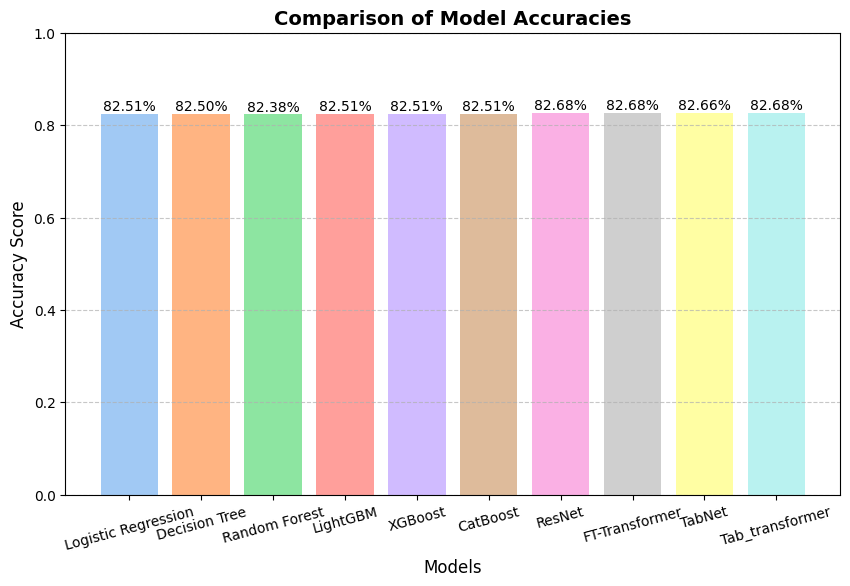

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()